In [1]:
from typing import Union, Iterable, Hashable, Callable, List
from functools import partial
import re

import pandas as pd
import xarray as xr
from pyproj import Transformer
import pylab as plt
from pathlib import Path

In [2]:
def preprocess_nc(
    ds: xr.Dataset,
    regexp: str = "id_(.+?)_",
    dim: str = "exp_id",
    drop_vars: Union[str, Iterable[Hashable], Callable[[xr.Dataset], Union[str, Iterable[Hashable]]]] = ["nv4"],
    drop_dims: List[str] = ["nv4"],
) -> xr.Dataset:
    """
    Add experiment 'exp_id' to the dataset and drop specified variables and dimensions.

    This function adds an experiment id ('exp_id') to the dataset, extracted from the source encoding
    using the provided regular expression. It then drops the specified variables and dimensions from the dataset.

    Parameters
    ----------
    ds : xr.Dataset
        The dataset to be preprocessed.
    regexp : str, optional
        The regular expression used to extract the experiment id from the source encoding, by default "id_(.+?)_".
    dim : str, optional
        The name of the dimension to be added to the dataset, by default "exp_id".
    drop_vars : Union[List[str], None], optional
        The variables to be dropped from the dataset, by default None.
    drop_dims : List[str], optional
        The dimensions to be dropped from the dataset, by default ["nv4"].

    Returns
    -------
    xr.Dataset
        The preprocessed dataset.
    """

    m_id_re = re.search(regexp, ds.encoding["source"])
    ds.expand_dims(dim)
    assert m_id_re is not None
    m_id: Union[str, int]
    try:
        m_id = int(m_id_re.group(1))
    except:
        m_id = str(m_id_re.group(1))
    ds[dim] = m_id
    return ds.drop_vars(drop_vars, errors="ignore").drop_dims(drop_dims, errors="ignore")


In [61]:
jib = xr.open_dataset("/mnt/storstrommen/pism-greenland/data_sets/ocean/fldmean_jib_ocean_forcing_id_ctrl_1980_2020.nc").squeeze()

In [4]:
ps = Path("/mnt/storstrommen/pism-greenland/data_sets/ocean/").glob("MAR3.9_*_ocean_1960-2100_v4.nc")
ps = [p for p in ps if "ctrl_proj" not in p.name]
ds = xr.open_mfdataset(ps, 
                       parallel=True,
                       chunks="auto",
                       preprocess=partial(preprocess_nc, regexp="MAR3.9_(.+?)_ocean"),
                       combine="nested",
                       concat_dim="exp_id")


/home/andy/miniforge3/envs/pism-ragis/lib/python3.11/site-packages/xarray/core/dataset.py:4743: UserWarning: No index created for dimension exp_id because variable exp_id is not a coordinate. To create an index for exp_id, please first call `.set_coords('exp_id')` on this object.
  warnings.warn(


In [7]:
recon = xr.open_dataset("/home/andy/Downloads/FinalOutput/generatedTF_allglaciersinshore_MIROCES2L_MembersAverage_hist2100ssp585.nc")

In [10]:
def decimal_year_to_datetime(decimal_year):
    year = int(decimal_year)
    rem = decimal_year - year

    base = datetime(year, 1, 1)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)

    return result

In [11]:
decimal_year = recon.time.to_numpy()
datetimes = [decimal_year_to_datetime(year) for year in decimal_year]
glacier = recon.Glacier.to_numpy()
realization = recon.RealizationNumber.to_numpy()
theta_ocean = recon.TF.to_numpy()
lat = recon.lat.to_numpy()
lon = recon.lon.to_numpy()

r_ds = xr.Dataset(coords={"time": datetimes, "glacier": glacier, "realization": realization},
                 data_vars={"lat": (["glacier"], lat),
                            "lon": (["glacier"], lon),
                            "theta_ocean": (["realization", "glacier", "time"], theta_ocean, {"units": "K"})})

In [12]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3413")

In [13]:
x, y = transformer.transform(r_ds.lat, r_ds.lon)
X = xr.DataArray(x, coords={"glacier": glacier}, name="x")
Y = xr.DataArray(y, coords={"glacier": glacier}, name="y")
r_ds = xr.merge([r_ds, X, Y])

In [14]:
gcms = ds.sel(time=slice("1980-01-01", "2010-01-01"))
reanalysis = r_ds.sel(time=slice("1980-01-01", "2010-01-01")).rolling(time=13).mean()

/home/andy/miniforge3/envs/pism-ragis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


KeyboardInterrupt: 

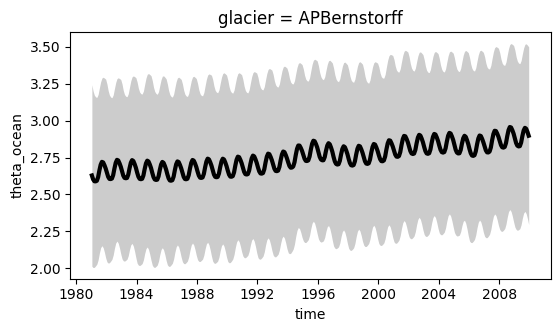

In [46]:
for k, g in enumerate(reanalysis.glacier):
    reanalysis_glacier = reanalysis.isel(glacier=k)
    pos = {"x": reanalysis_glacier.x, "y": reanalysis_glacier.y}
    gcm_theta = gcms.sel(pos, method="nearest").theta_ocean
    reanalysis_theta = reanalysis_glacier.theta_ocean
    reanalysis_theta_mean = reanalysis_theta.mean(dim="realization")
    reanalysis_theta_std = reanalysis_theta.std(dim="realization")
    fig, ax = plt.subplots(1, 1, figsize=(6.2, 3.2))
    ax.fill_between(reanalysis_theta_mean.time, reanalysis_theta_mean - reanalysis_theta_std, reanalysis_theta_mean + reanalysis_theta_std, 
                    color="k", alpha=0.20, lw=0)
    reanalysis_theta_mean.plot.line(color="k", lw=3, ax=ax)
    gcm_theta.plot.line(x="time", hue="exp_id", ax=ax, add_legend=False)        
    glacier_name = reanalysis_theta.glacier.values
    ax.set_title(glacier_name)
    fig.tight_layout()
    fig.savefig(f"{glacier_name}.pdf")

/home/andy/miniforge3/envs/pism-ragis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


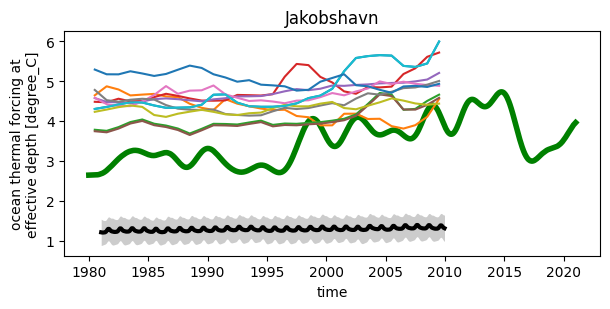

In [63]:
    k = 86
    reanalysis_glacier = reanalysis.isel(glacier=k)
    pos = {"x": reanalysis_glacier.x, "y": reanalysis_glacier.y}
    gcm_theta = gcms.sel(pos, method="nearest").theta_ocean
    reanalysis_theta = reanalysis_glacier.theta_ocean
    reanalysis_theta_mean = reanalysis_theta.mean(dim="realization")
    reanalysis_theta_std = reanalysis_theta.std(dim="realization")
    fig, ax = plt.subplots(1, 1, figsize=(6.2, 3.2))
    ax.fill_between(reanalysis_theta_mean.time, reanalysis_theta_mean - reanalysis_theta_std, reanalysis_theta_mean + reanalysis_theta_std, 
                    color="k", alpha=0.20, lw=0)
    reanalysis_theta_mean.plot.line(color="k", lw=3, ax=ax)
    jib.theta_ocean.plot.line(hue="exp_id", ax=ax, lw=4, color="g")
    gcm_theta.plot.line(x="time", hue="exp_id", ax=ax, add_legend=False)        
    glacier_name = reanalysis_theta.glacier.values
    ax.set_title(glacier_name)
    fig.tight_layout()
    fig.savefig(f"{glacier_name}.pdf")


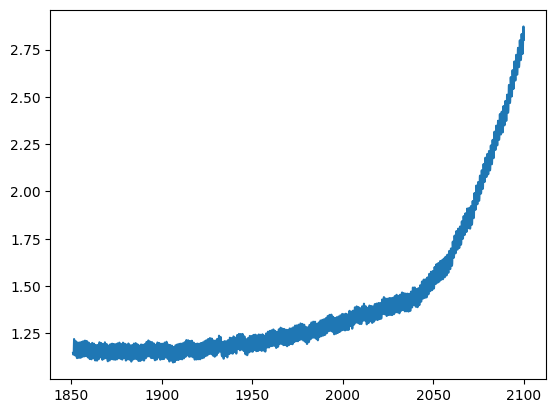

In [80]:
time = recon.time
plt.figure()
tf = recon.isel(glacierDim=86).TF.mean(dim="realizDim").rolling(timeDim=13).mean()
plt.plot(time, tf)

In [75]:
tf.shape

(3000,)

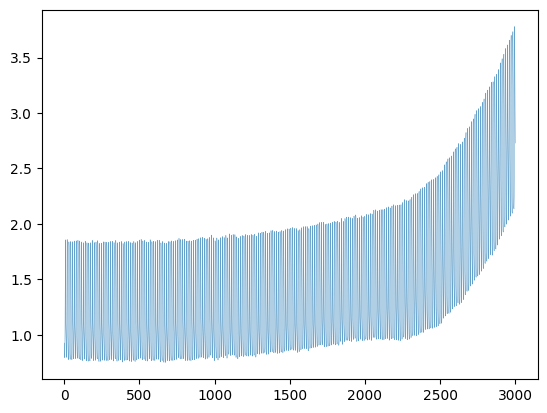

In [77]:
plt.plot(tf, lw=0.25)